In [5]:
import pandas as pd
import csv
import os
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score

In [6]:
folder_path = "D:\Projects\Traffic-Classification-Research\Datasets\QUIC"


def get_data(samples):
    all_sessions = []
    labels = []
    for label in os.listdir(folder_path):
        label_folder_path = os.path.join(folder_path, label)
        if os.path.isdir(label_folder_path):
            for filename in os.listdir(label_folder_path):
                file_path = os.path.join(label_folder_path, filename)
                # Converting each session to Panda's DataFrame and restricting the number of rows. 
                session_df = pd.read_csv(file_path, sep="\t", header=None, skiprows=4, nrows=samples)
                # Giving names to the columns (features).
                session_df.columns = ['Timestamp', 'Time Difference', 'Packet Size', 'Direction']
                # Adding to the collection.
                if not session_df.empty:
                    all_sessions.append(session_df)
                    labels.append(label)
    # Merge all DataFrames to one DataFrame.
    all_data = pd.concat(all_sessions, ignore_index=True)
    return labels, all_sessions, all_data

In [7]:
results = pd.DataFrame(columns=['Samples','Test Accuracy','Test Recall','Test Precision','Test F1-Score'])
# Running the model for different number of samples.
for samples in range(10,200,10):
    labels, all_sessions, all_data = get_data(samples)
    from sklearn.model_selection import train_test_split
    # Splitting the data to 30% Test, 70% Train.
    X_train, X_test, y_train, y_test = train_test_split(all_sessions, labels, test_size=0.3, random_state=42)

    # Normalizing the features to the range (0,1).
    scaler = MinMaxScaler()
    for session in X_train:
        scaler.fit(session[['Time Difference', 'Packet Size']])
        session[['Time Difference', 'Packet Size']] = scaler.transform(session[['Time Difference', 'Packet Size']])
    for session in X_test:
        session[['Time Difference', 'Packet Size']] = scaler.transform(session[['Time Difference', 'Packet Size']])
    # Creating a list of the time series.
    X_train = [session[['Time Difference', 'Packet Size', 'Direction']].values for session in X_train]
    X_test = [session[['Time Difference', 'Packet Size', 'Direction']].values for session in X_test]
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    X_train = pad_sequences(X_train, dtype='float32')
    X_test = pad_sequences(X_test, dtype='float32')
    import numpy as np
    labels = np.array(labels)
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv1D,Flatten,MaxPooling1D,LSTM

    from sklearn.preprocessing import LabelEncoder
    # Encoding the labels.
    le = LabelEncoder()
    le.fit(y_train)
    # Converting all the labels to numerical values.
    y_train_le = le.transform(y_train)
    y_test_le = le.transform(y_test)

    # Initializing the model.
    model = Sequential()
    # Adding layer to the model.
    model.add(Conv1D(32, kernel_size=3, strides=1, activation='selu', input_shape=X_train[0].shape))
    model.add(MaxPooling1D())
    model.add(Conv1D(32,kernel_size=3, strides=1, activation='selu'))
    model.add(MaxPooling1D())
    # Adding a layer to conert the results of the previous layers to a 1 dimensional vector.
    model.add(Flatten())
    # Adding a final layer for the classification.
    model.add(Dense(5, activation='softmax'))
    # Compiling the model.
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    # Training the model.
    model.fit(X_train, y_train_le, epochs=50, batch_size=32, validation_data=(X_test, y_test_le),callbacks=[early_stopping])
    # Computing and outputting the results.
    loss, accuracy = model.evaluate(X_test, y_test_le)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)
    y_pred = model.predict(X_test)
    
    # add to results dataframe without using append
    curr_res = pd.DataFrame(
    [[samples,
      accuracy,
      recall_score(y_test_le, y_pred.argmax(axis=1), average='micro'),
      precision_score(y_test_le, y_pred.argmax(axis=1), average='micro'),
      f1_score(y_test_le, y_pred.argmax(axis=1), average='micro')]],
    columns=['Samples', 'Test Accuracy', 'Test Recall', 'Test Precision', 'Test F1-Score']
    )
    results = pd.concat([results, curr_res], ignore_index=True)

Epoch 1/50
141/141 [==============================] - 1s 5ms/step - loss: 1.0840 - accuracy: 0.5915 - val_loss: 30.0772 - val_accuracy: 0.4218
Epoch 2/50
141/141 [==============================] - 1s 4ms/step - loss: 0.7420 - accuracy: 0.7371 - val_loss: 51.3370 - val_accuracy: 0.3002
Epoch 3/50
141/141 [==============================] - 0s 3ms/step - loss: 0.6147 - accuracy: 0.7812 - val_loss: 66.9033 - val_accuracy: 0.2919
Epoch 4/50
141/141 [==============================] - 0s 3ms/step - loss: 0.5526 - accuracy: 0.8158 - val_loss: 79.0909 - val_accuracy: 0.2769
Epoch 5/50
141/141 [==============================] - 0s 3ms/step - loss: 0.5051 - accuracy: 0.8223 - val_loss: 80.6948 - val_accuracy: 0.2655
Epoch 6/50
61/61 [==============================] - 0s 2ms/step - loss: 30.0772 - accuracy: 0.4218
Test Loss: 30.077220916748047
Test Accuracy: 0.42184266448020935
61/61 [==============================] - 0s 1ms/step
Epoch 1/50
141/141 [==============================] - 1s 5ms/step - 

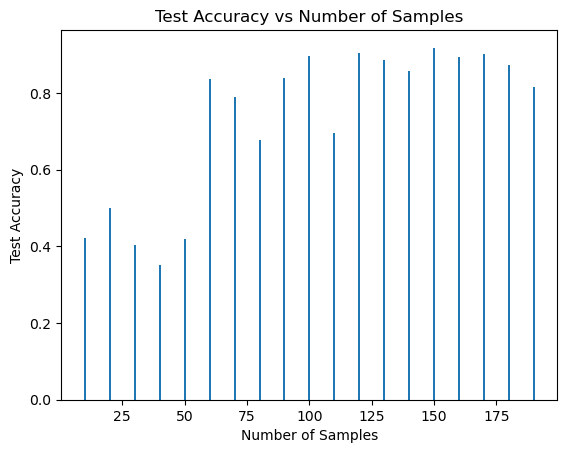

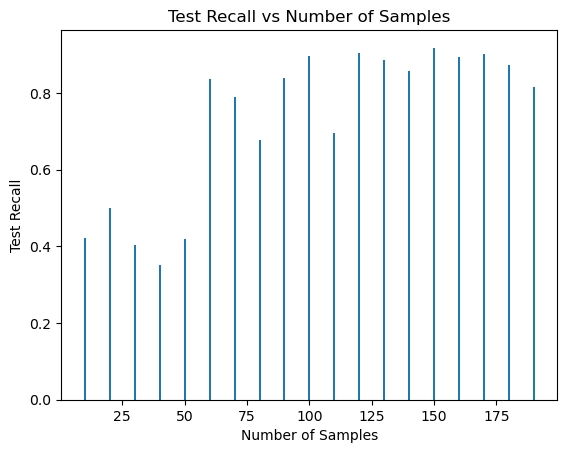

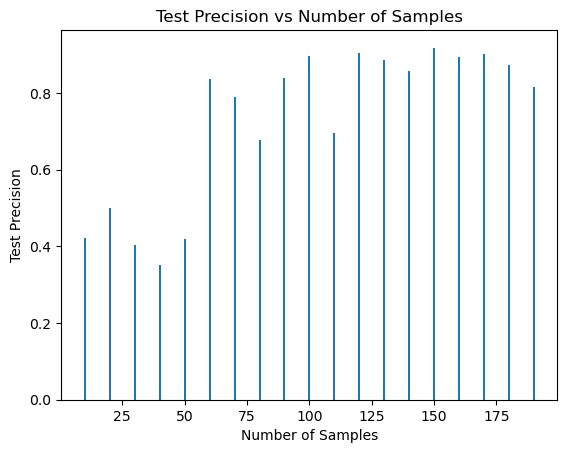

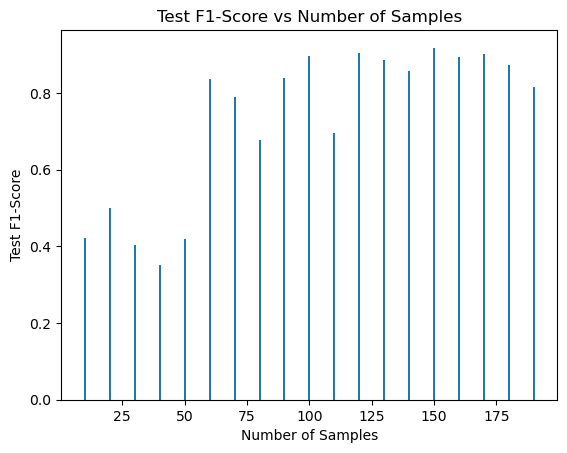

In [8]:
import matplotlib.pyplot as plt
# create bar plots for each metric, x_axis is the number of samples, y_axis is the metric value
def plot_bar(metric):
    plt.bar(results['Samples'], results[metric])
    plt.xlabel('Number of Samples')
    plt.ylabel(metric)
    plt.title(metric + ' vs Number of Samples')
    plt.show()

plot_bar('Test Accuracy')
plot_bar('Test Recall')
plot_bar('Test Precision')
plot_bar('Test F1-Score')

# save results to csv file
results.to_csv('results_quic_text.csv', index=False)